In [5]:
from data.Safe2Unsafe import DeepAccidentDataset
from method.dynamics import InDCBFAttentionDynamics, InDCBFDynamics
from method.barriers import InDCBFAttentionBarrier, InDCBFBarrier
from method.dynamics import SABLASDynamics, SABLASUnFusedDynamics
from method.barriers import SABLASBarrier, SABLASBarrierUnfused
from method.trainers import InDCBFTrainer, SABLASTrainer
import torch
import time
import pytorch_lightning as pl
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
data = DeepAccidentDataset(train_batch_size=32,val_batch_size=32,num_workers=16)
data.setup()
train_dataloader = data.train_dataloader()
test_dataloader = data.test_dataloader()
latent_dim = 16

In [4]:
backbones = ['vit','clip','vc1','resnet']
b2m = {'vit':"google/vit-base-patch16-224",'clip':"openai/clip-vit-base-patch16",'vc1':"vc1",'resnet':"resnet50"}
backbone = 'vit'


In [9]:
import numpy as np
backbones = ['vit','clip','vc1','resnet']
output = []
for backbone in backbones:
    loss_all = []
    for seed in ['42','43','44','45','46']:
        total_loss = 0
        step = 0
        seed = 42
        model_name = b2m[backbone]
        barrier = InDCBFAttentionBarrier(2,latent_dim=latent_dim)
        model = InDCBFAttentionDynamics(2,"cuda",model=model_name,latent_dim=latent_dim)
        trainer = InDCBFTrainer(model,barrier)
        checkpoint = torch.load(f"/root/autodl-tmp/logs/InDCBF_{backbone}_{seed}/version_0/checkpoints/last.ckpt")
        trainer.load_state_dict(checkpoint['state_dict'])
        trainer.to("cuda")
        for idx, (i,u,label) in enumerate(test_dataloader):
            i, u = i.to("cuda"), u.to("cuda")
            x,x_tide = trainer.model.simulate(i,u,window_size=1)
            test_loss = trainer.model.loss_function(x,x_tide)
            total_loss += (test_loss['loss_latent']/x.shape[0]).detach().cpu().numpy()
            step += 1
        loss_all.append(total_loss/step)
    output.append(f"{backbone}:{np.mean(loss_all)}$\pm${np.std(loss_all)}")
    print(f"{backbone}:{np.mean(loss_all)}$\pm${np.std(loss_all)}")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [00:00<00:00, 15.28it/s]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [00:00<00:00, 14.67it/s]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [00:0

vit:0.0009184606195049127$\pm$0.0


100%|██████████| 4/4 [00:00<00:00, 17.11it/s]


clip:0.0018067139276536181$\pm$0.0


100%|██████████| 4/4 [00:00<00:00, 18.23it/s]


vc1:0.0010677896390552633$\pm$0.0


100%|██████████| 4/4 [00:00<00:00, 23.43it/s]


resnet:0.0011133219320618082$\pm$0.0


In [11]:
loss_all

[0.0011133219320618082,
 0.0011133219320618082,
 0.0011133219320618082,
 0.0011133219320618082,
 0.0011133219320618082]

In [10]:
print(output)

['vit:0.0009184606195049127$\\pm$0.0', 'clip:0.0018067139276536181$\\pm$0.0', 'vc1:0.0010677896390552633$\\pm$0.0', 'resnet:0.0011133219320618082$\\pm$0.0']


In [14]:
import numpy as np
backbones = ['vit','clip','vc1','resnet']
output = []
for backbone in backbones:
    loss_all = []
    for seed in ['42','43','44','45','46']:
        total_loss = 0
        step = 0
        seed = 42
        model_name = b2m[backbone]
        barrier = InDCBFAttentionBarrier(2,latent_dim=latent_dim)
        model = InDCBFAttentionDynamics(2,"cuda",model=model_name,latent_dim=latent_dim)
        trainer = InDCBFTrainer(model,barrier)
        checkpoint = torch.load(f"/root/tf-logs/SABLAS_{backbone}_{seed}/version_0/checkpoints/last.ckpt")
        trainer.load_state_dict(checkpoint['state_dict'])
        trainer.to("cuda")
        for idx, (i,u,label) in enumerate(test_dataloader):
            i, u = i.to("cuda"), u.to("cuda")
            x,x_tide = trainer.model.simulate(i,u)
            f,g = trainer.model.ode(x)
            gu = torch.einsum('btha,bta->bth',g.view(g.shape[0],g.shape[1],f.shape[-1],2),u)
            derive = f + gu
            x_nom = x + derive*0.1
            test_loss = trainer.model.loss_function(x[:,1:,:],x_nom[:,:-1,:])
            total_loss += (test_loss['loss_latent']/x.shape[0]).detach().cpu().numpy()
            step += 1
        loss_all.append(total_loss/step)
    output.append(f"{backbone}:{np.mean(loss_all)}$\pm${np.std(loss_all)}")
    print(f"{backbone}:{np.mean(loss_all)}$\pm${np.std(loss_all)}")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [00:00<00:00, 16.08it/s]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [00:00<00:00, 18.45it/s]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4/4 [00:0

vit:1.1289216682501138$\pm$0.0


100%|██████████| 4/4 [00:00<00:00, 17.08it/s]


clip:0.0487741599639412$\pm$0.0


100%|██████████| 4/4 [00:00<00:00, 16.51it/s]


vc1:0.024460620160680263$\pm$0.0


100%|██████████| 4/4 [00:00<00:00, 25.14it/s]


resnet:3.156185198277235$\pm$0.0


In [15]:
output

['vit:1.1289216682501138$\\pm$0.0',
 'clip:0.0487741599639412$\\pm$0.0',
 'vc1:0.024460620160680263$\\pm$0.0',
 'resnet:3.156185198277235$\\pm$0.0']

In [3]:
import os
from torchvision.io import read_image
from torchvision import transforms
import torch
image_folder = "/root/DeepAccident/data/DeepAccident_data/type1_subtype1_accident/other_vehicle_behind/Camera_Front/Town05_type001_subtype0001_scenario00009"
label_path = "/root/DeepAccident/data/DeepAccident_data/type1_subtype1_accident/other_vehicle_behind/label/Town05_type001_subtype0001_scenario00009"
CAMERA_LOC = ["Camera_Back","Camera_BackLeft","Camera_BackRight","Camera_Front","Camera_FrontLeft","Camera_FrontRight"]
DATA_PATH = "/root/autodl-tmp/data/DeepAccident_data"
trajectory = "Town05_type001_subtype0001_scenario00009"
agent = "other_vehicle_behind"
traj_type = "type1_subtype1_accident"
transform = transforms.Compose([
            transforms.Resize((224, 224)),     
        ])
image_list = os.listdir(image_folder)
length = len(image_list)
imgs_all = []
u = []
for i in range(1,length+1):
    info_name = "{}_{:03d}.txt".format(trajectory,i)
    info_path = os.path.join(label_path,info_name)
    with open(info_path,'r') as f:
        action = f.readline().strip().split(" ")
    u.append(torch.Tensor([float(action[0]),float(action[1])]))
    imgs = []
    for cam_idx in CAMERA_LOC:
        camera_path = os.path.join(DATA_PATH,traj_type,agent,cam_idx,trajectory)
        img_name = "{}_{:03d}.jpg".format(trajectory,i)
        img_path = os.path.join(camera_path,img_name)
        img = read_image(img_path)/255
        sample = transform(img)
        imgs.append(sample)
    imgs = torch.stack(imgs,dim=0)
    imgs_all.append(imgs)
i, u =  torch.stack(imgs_all,dim=0), torch.stack(u,dim=0)

In [6]:

b2m = {'vit':"google/vit-base-patch16-224",'clip':"openai/clip-vit-base-patch16",'vc1':"vc1",'resnet':"resnet50"}
backbones = ['vit','clip','vc1','resnet']
xs = []
for backbone in backbones:
    seed = 42
    latent_dim = 16
    model_name = b2m[backbone]
    barrier = InDCBFAttentionBarrier(2,latent_dim=latent_dim)
    model = InDCBFAttentionDynamics(2,"cuda",model=model_name,latent_dim=latent_dim)
    trainer = InDCBFTrainer(model,barrier)
    checkpoint = torch.load(f"/root/autodl-tmp/logs/InDCBF_{backbone}_{seed}/version_0/checkpoints/last.ckpt")
    trainer.load_state_dict(checkpoint['state_dict'])
    trainer.to("cuda")
    i, u = i.to("cuda"), u.to("cuda")
    x,x_tide = trainer.model.simulate(i.unsqueeze(0),u.unsqueeze(0))
    xs.append(x)
xs = torch.cat(xs,dim=0)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 60/60 [00:00<00:00, 77.19it/s]


In [8]:
rep = xs.detach().cpu().numpy().reshape(-1,16)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(rep).reshape(4,xs.shape[1],2)

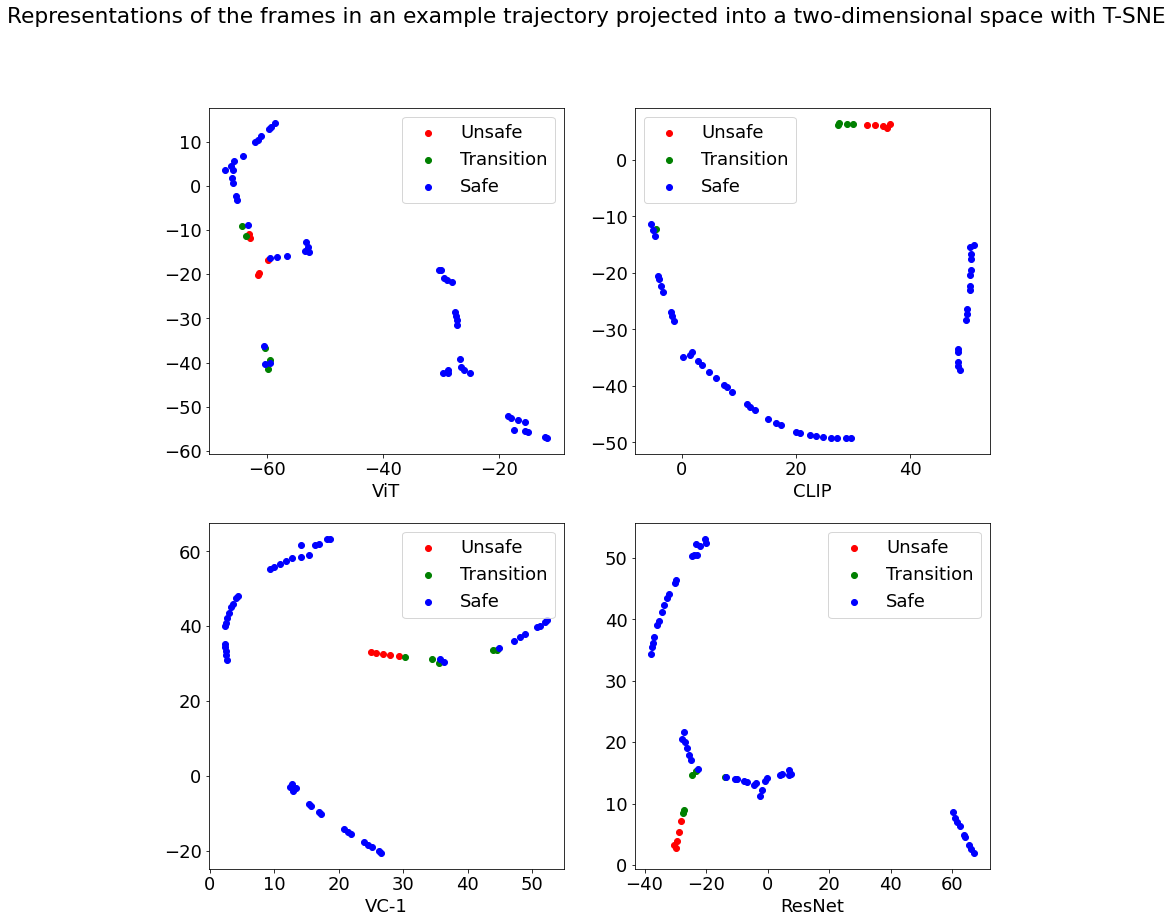

In [26]:
plt.rcParams.update({"font.size":18})
plt.figure(figsize=(14,14))
plt.tight_layout()
plt.title(f"The representation in two-dimensional space with ViT backbone")
name = ['ViT','CLIP','VC-1','ResNet']
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(X_embedded[i,56:61,0],X_embedded[i,56:61,1],c='red',label='Unsafe')
    plt.scatter(X_embedded[i,51:56,0],X_embedded[i,51:56,1],c='green',label='Transition')
    plt.scatter(X_embedded[i,:51,0],X_embedded[i,:51,1],c='blue',label='Safe')
    plt.legend()
    plt.xlabel(f"{name[i]}")
# plt.suptitle("Representations of the frames in an example trajectory projected into a two-dimensional space with T-SNE")
plt.show()

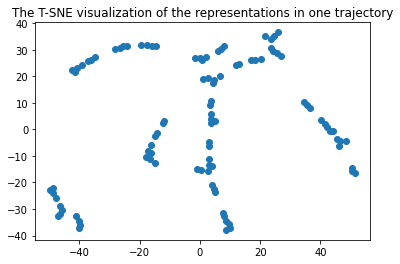

In [16]:
rep = x.detach().cpu().numpy()
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(rep)
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.title("The T-SNE visualization of the representations in one trajectory")
plt.show()